#### Physics 731R Final Project
##### Mitchell Scott
##### Prof. Ilya Nemenman
##### Random Matrix Theory
##### Spring 2024

Dirichlet Random Matrices


# Introduction
Throughout the course, we encountered many "classic" models for random matrices such as Gaussian Orthogonal, Unitary, and Symplectic Ensembles (GOE, GUE, and GSE, respectively), where there are many famous results as these ensembles are very well studied. However, they all rely on the assumption that each individual element was samples indepedently from the Gaussian distribution. While independence between all entries has very nice theoretically guarentees, it is not always a reasonable assumption in modeling phenomenon in the real world. In the report, we relax the assumption of independence slightly and turn our attention to two different distributions -- the Dirichlet and its univariate, beta distribution. To do this, we construct row vectors $v_i$ that are sampled from the respective distributions and then normalized so that the $\|v_i\|_\infty = 1, \forall i=1,2,\cdots.$ Because the entries in a row are normalized against each other, entries in a row are not independent. However, when we stack these row vectors on top of one another to form a random matrix, these disparate rows are indendent. In both the Dirchlet and beta distribution there is a sparsity promoting (hyper)parameter $\beta$ that when it is small, we see a sparse matrix with a few nonzeros per row of substantial magnitude. Conversely, as $\beta$ gets large, we see a fully dense matrix where each value is close to uniform in magnitude.

This model has many applications in machine learning applications such as randomly assigning weights to a complex neural network. At each level, the network has to output everything that it input which is equivalent to the weights at each layer summing to 1. By manipulating this $\beta$ and randomly assigning weights to the nodes, we are essentially able to promote a sparse neural network, with many "dead nodes". By investigating these Dirichlet and beta random matrices, we hope to gain a better understanding on their spectral properties, such as the distribution of their eigenvalues and and how this spectral distribution depends on parameters like $\beta$ or $q = N/T$, where $N$ is the number of columns or variables and $T$ is the number of rows or trials in the model. 

The paper is organized as follow: first, in section 2, we mathematically explain the model for both the beta and Dirichlet distribution, then we show small proof of concept matrices numerically generated that verify our code. In section 3, we analyze the covariance matrices for these beta and Dirichlet random matrices both numerically and analyticly. In section 4, we investigate if self averaging is important for the convergence of the spectrum to a distribution. Additionally, we analyze how the spectrum responds to different changes in parameters and relate it to the Marchenko - Pastur distribution. Lastly, in section 5, we summarize our results and explore future directions for this project.

# Beta and Dirichlet Random Matrix Model
## Beta Random Matrix Model
First, we define the Beta distribution, which is a univariate generalization of the Dirichlet distribution. The probability density function of the beta distribution for a univariate $x\in[0,1]$ has two shape parameters, which we will use to construct the $\beta$ hyper-parameter, $\beta = [a,b]^\top$, which control the growth of small and large values of $x$ respectively, ($a,b>0$). Mathematically, we have the PDF of the beta distribution is
\begin{align}
f(x; a,b) &= \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)} x^{a-1}(1-x)^{b-1},
\end{align}
where $\Gamma(\cdot)$ is the Gamma function. This distribution is implimented through the \texttt{numpy} package in python, so we call that function to draw from this distribution. Lastly, we normalize the variables in each row to enforce the sum to 1 constraint. This is what motivates the code below, as well as a visual row vector that displays the sparsity for small $\beta$, and uniformity for large $\beta$. In the first figure, where $\beta = 0.001$, we see all entries are zero except the last which is 1.0. In the second figure, where $\beta = 1000$, we see all values are very close to uniform at $0.1\bar{6} = \frac{1}{6}$. Lastly, to make a beta random matrix, we call this code for the $i^{\text{th}}$ row, $i=1,...,T$. This function is called $\texttt{betaRM}$. Again, we present a small $3\times 10$ beta random matrix for the two extreme cases, $\beta = 0.001, 1000$, and observe the same properties as above, namely sparsity and uniformity, respectively.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import matlib
from numpy import linalg as LA
import scipy as sp

In [2]:
rng = np.random.default_rng()

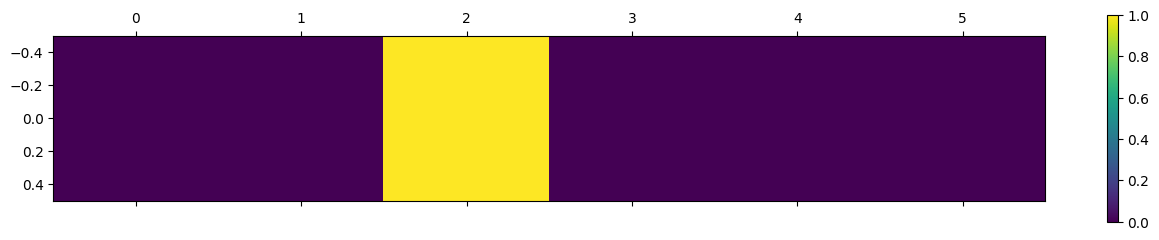

In [18]:
samplelow = rng.beta(a=0.0001, b=0.0001, size=(1,6))
samplelow = [v / np.sum(samplelow) for v in samplelow]

plt.matshow(samplelow)
plt.colorbar()
plt.show()

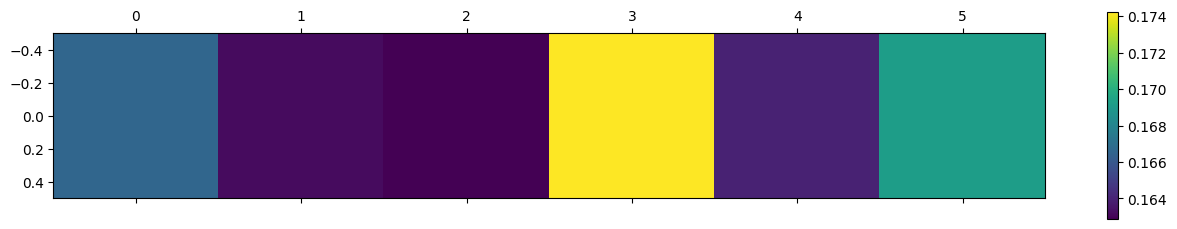

In [19]:
samplehi = rng.beta(a=1000, b=1000, size=(1,6))
samplehi = [v / np.sum(samplehi) for v in samplehi]

plt.matshow(samplehi)
plt.colorbar()
plt.show()

In [24]:
def betaDist(N,a,b):
    # Defines a N length vector which is drawn from a normalized Beta distribution with parameters a, b
    sample = rng.beta(a=a, b=b, size=(1,N))
    sample = np.array([v / np.sum(sample) for v in sample])
    return sample

In [25]:
def betaRM(T,N,a,b):
    # Defines a T x N Random Matrix where each row is a normalized Beta distribution with parameters a, b
    mat = np.zeros((T,N))

    for i in range(T):
        mat[i,:] = betaDist(N,a,b)
        
    return mat

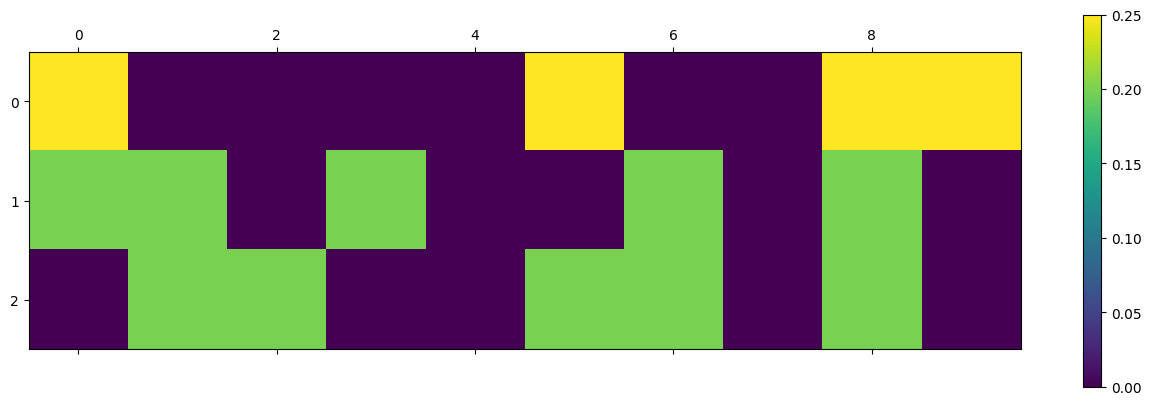

In [45]:
matlow = betaRM(3,10,0.00000001,0.00000001)
plt.matshow(matlow)
plt.colorbar()
plt.show()

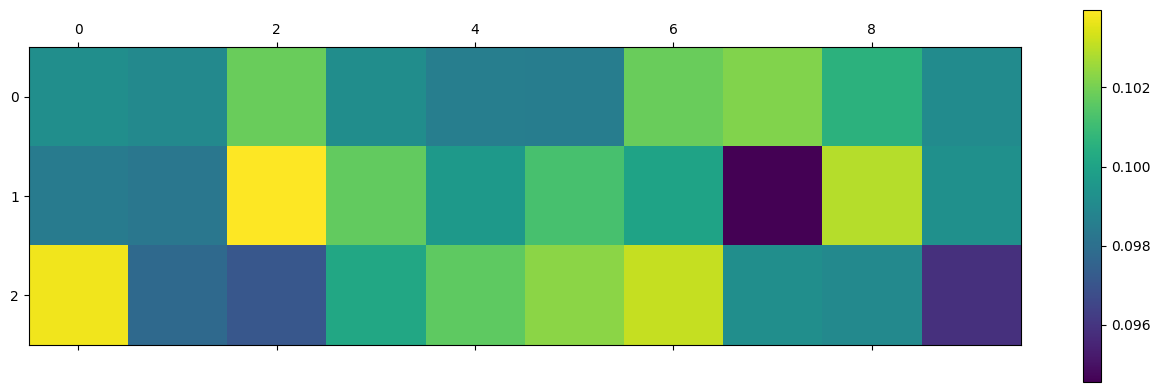

In [46]:
mathi = betaRM(3,10,1000,1000)
plt.matshow(mathi)
plt.colorbar()
plt.show()

## Dirichlet Random Matrix Model
As we already noted, the Dirichlet distribution was a multivariate form of the beta distribution, so it shouldn't be a suprise to see that for $K\geq 2$ parameters $\beta = [\alpha_1,\alpha_2,\cdots,\alpha_K]^\top$, where $\alpha_i>0,\forall i$ and $x_i \in [0,1] \forall i =1,\cdots, K$ such that $\sum_{i=1}^K x_i = 1$, the PDF is given as 
\begin{align}
f(x_1,\cdots, x_K; \beta) &= f(x_1,\cdots, x_K; \alpha_1,\cdots,\alpha_K)\\
&= \frac{\Gamma\left(\sum_{i=1}^K \alpha_i\right)}{\prod_{i=1}^K \Gamma(\alpha_i)} \prod_{i=1}^K x_i^{\alpha_i - 1}.
\end{align}
Setting $K=2$, we see the beta distribution. While the beta distribution was already a function in the $\texttt{numpy}$ package, the Dirichlet distribution was not, so we needed to find a way to uniformly sample from the Dirichlet distribution. Luckily, [this source](https://en.wikipedia.org/wiki/Dirichlet_distribution#Random_variate_generation) details exactly how to sample if you have access to a gamma distribution. To sample a random vector $x = [x_1, \cdots, x_K]^\top$ from a $K$-dimensional Dirichlet distribution, with parameters $\beta = [\alpha_1,\cdots,\alpha_K]^\top$, we first must draw $K$ independent samples from the gamma distribution and then normalize them to sum to 1. Mathematically, we have
\begin{align}
\text{Gamma}(\alpha_i, 1) &= \frac{y_i^{\alpha_i - 1}e^{-y_i}}{\Gamma(\alpha_i)}\\
x_i &= \frac{y_i}{\sum_{j=1}^K y_j}.
\end{align}

Since the $\texttt{numpy}$ pagacke has a gamma distribution, this is exactly what is done in $\texttt{dirDist}$ to generate a $K$ dimensional Dirichlet sample. The above resource also outlines a less efficient way of sampling from the Dirichlet distribution that relies on the univariate Beta distribution and conditioning on this many times, which has been used in practice in papers like [Fleig, Nemenman, '22](https://arxiv.org/pdf/2212.02987). Just like in the beta case, we stack these $K$-dimensional vectors on top of each other $T$ times to create a $T\times K$ Dirichlet random matrix. To test the accuracy of the code, we generate two $3\times 10$ matrices with $\beta = 0.001, 1000$, in the two figures below, respectively. Again, we observe the familiar sparsity and uniformity.

In [20]:
def dirDist(params):
    sample = [rng.gamma(a, 1) for a in params]
    sample = np.array([v / sum(sample) for v in sample])
    return sample

In [21]:
def dirRM(T,params):
    # Defines a T x N Random Matrix where each row is a normalized Dirichlet distribution with parameters a1,a2,...,aN
    mat = np.zeros((T,len(params)))

    for i in range(T):
        mat[i,:] = dirDist(params)
        
    return mat

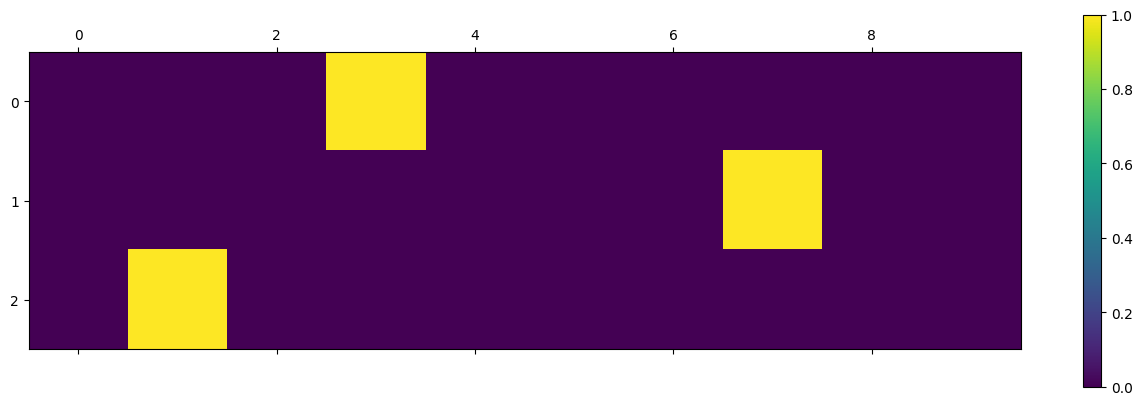

In [22]:
params = 0.001 * np.ones((10))
samplelow = dirRM(3,params)

plt.matshow(samplelow)
plt.colorbar()
plt.show()

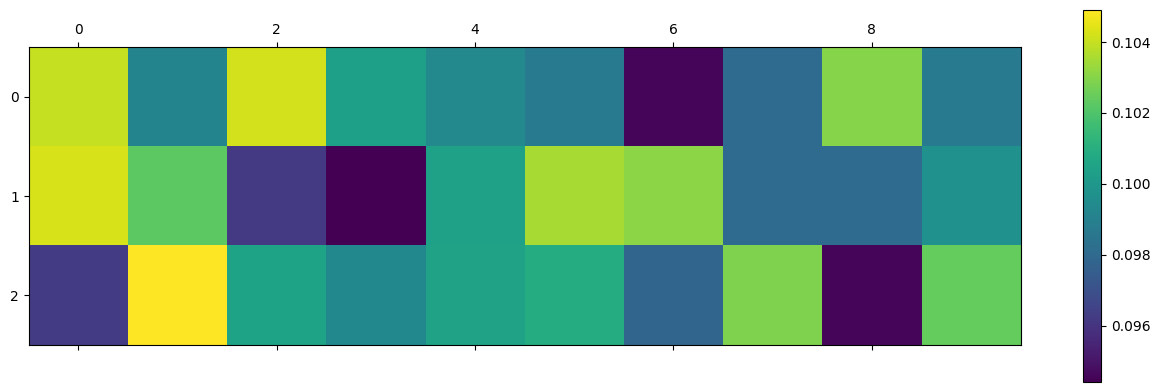

In [23]:
params = 1000*np.ones((10))
samplehi = dirRM(3,params)

plt.matshow(samplehi)
plt.colorbar()
plt.show()

# Covariance Matrices for Dirichlet Random Matrices

While it is great to be able to generate these beta and Dirichlet random matrices, unless $q = N/T = 1$, we cannot have eigenvalues, as we require square matrices to have a spectrum. However, by constructing the covariance matrix (called sample covariance matrix in Potters and Bouchaud's random matrix theory text), we will always have a square matrix, so the spectrum is always well defined. For an $N\times T$ data matrix $\mathbf{H}$, where $N$ is the number of variables and $T$ is the number of observations, we can define the covariance matrix as 
\begin{align}
\mathbf{E} &= \frac{1}{T}\mathbf{HH}^\top.
\end{align}
A quick computation shows that $\mathbf{E}$ is symmetric and positive semi-definite, which means $\lambda_i(\mathbf{E})\geq 0$, so it is diagonalizable by the spectral theorem. Since we have defined our random matrices $\mathbf{A}$ as $T\times N$ matrices, we will always compute the covariance matrix of $\mathbf{A}^\top$. Additionally, we could compute the covariance matrix of $\mathbf{A}$, which is similar to how Potters and Bouchaud define 
\begin{align}
\mathbf{F} = \frac{1}{N}\mathbf{H}^\top\mathbf{H},
\end{align}
which results in $\mathbf{F}\in\mathbb{R}^{T\times T}$, as $\mathbf{H}$ is $N\times T$; however analysis of one of the two suffices as $T\mathbf{A}^\top$ and $N\mathbf{A}$ have the same nonzero eigenvalues, and the difference is just in the amount of trivial eigenvalues. We next turn our attention to mathematically observing the trends of the covariance matrix of $\mathbf{A}^\top$.

## Analysis of Extreme $\beta$ values

For this matrix if $\beta\ll0$, we expect there to be only one entry of $\mathcal{O}(1)$ in each row, and in the most extreme case, there is one 1 in a row and the rest of the elements are zero. We seek to use this model to analyze the covariance matrix.

Let's assume that there is a 1 in the $(i,j)$ position of the data matrix $\mathbf{A}$, which means all other elements in the $i^{\text{th}}$ row are zero. To analyze the covariance matrix of a $T\times N$ matrix, where $T$ is the number of trials or observations and $N$ is the number of variables in the model:
\begin{align}
    \mathbf{C} &= \frac{1}{T}\mathbf{A}^\top\mathbf{A}\\
    \left(\mathbf{C}\right)_{ij} &= \frac{1}{T}\sum_{k=1}^T a_{ik}a_{kj}\\
    &= \frac{1}{T}\delta_{ij},
\end{align}
where we used the fact that if $i=j$ then that value will be 1 if $a_{ki} = 1$, and 0 if $a_{ki} = 0$. This means that when the $\beta\ll 1$, we essentially have a scaled identity matrix, where the only iteractions are self iterations. This is illustrated below. Numerically, we see a sample covariance matrix with about $\frac{1}{T} = \frac{1}{5} = 0.2$ on the diagonal entries and 0 on the off diagonal entries.

Now let's consider the other extreme of the distribution, when $\beta\gg1$. If this is the case, all of the entries are going to be roughly equal with a little noise $\epsilon_{ij}$, where $|\epsilon_{ij}|\leq \epsilon_{mach}$ and these $\epsilon_{ij} \sim \mathcal{N}(0,\epsilon_{mach})$, and are forced to sum up to zero. Explicitly, when $\beta\gg 1$, we expect $\mathbf{A}\in\mathbb{R}^{T\times N}$, like
\begin{align}
\mathbf{A} &= \begin{pmatrix} \frac{1}{N} + \epsilon_{11} & \frac{1}{N} + \epsilon_{12} & \cdots & \frac{1}{N} + \epsilon_{1N}\\
\frac{1}{N} + \epsilon_{21} & \frac{1}{N} + \epsilon_{22} & \cdots & \frac{1}{N} + \epsilon_{2N}\\
\vdots & \vdots & \ddots & \vdots\\
\frac{1}{N} + \epsilon_{T1} & \frac{1}{N} + \epsilon_{T2} & \cdots & \frac{1}{N} + \epsilon_{TN}\\
\end{pmatrix}.
\end{align}

Then to analyze the covariance matrix $\mathbf{A}^\top\mathbf{A}$, we first turn our attention to a simple $2\times 3$ (so $N=3$) case:
\begin{align}
\mathbf{C} &= \frac{1}{T}\mathbf{A}^\top\mathbf{A}\\
&= \frac{1}{T} \begin{pmatrix} \frac{1}{N} + \epsilon_{11} & \frac{1}{N} + \epsilon_{12} & \frac{1}{N} + \epsilon_{13}\\
\frac{1}{N} + \epsilon_{21} & \frac{1}{N} + \epsilon_{22} & \frac{1}{N} + \epsilon_{23}\\
\end{pmatrix} \begin{pmatrix} \frac{1}{N} + \epsilon_{11} & \frac{1}{N} + \epsilon_{21} \\
\frac{1}{N} + \epsilon_{12} & \frac{1}{N} + \epsilon_{22}\\
\frac{1}{N} + \epsilon_{13} & \frac{1}{N} + \epsilon_{23}\\
\end{pmatrix}\\
&= \frac{1}{T}\begin{pmatrix}\left(\frac{1}{N} + \epsilon_{11}\right)^2 + \left(\frac{1}{N} + \epsilon_{12}\right)^2 + \left(\frac{1}{N} + \epsilon_{13}\right)^2  & \left(\frac{1}{N} + \epsilon_{11}\right)\left(\frac{1}{N} + \epsilon_{21}\right) + \left(\frac{1}{N} + \epsilon_{12}\right)\left(\frac{1}{N} + \epsilon_{22}\right) + \left(\frac{1}{N} + \epsilon_{13}\right)\left(\frac{1}{N} + \epsilon_{23}\right)\\
\left(\frac{1}{N} + \epsilon_{21}\right)\left(\frac{1}{N} + \epsilon_{11}\right) + \left(\frac{1}{N} + \epsilon_{22}\right)\left(\frac{1}{N} + \epsilon_{12}\right) + \left(\frac{1}{N} + \epsilon_{23}\right)\left(\frac{1}{N} + \epsilon_{13}\right)  & \left(\frac{1}{N} + \epsilon_{21}\right)^2 + \left(\frac{1}{N} + \epsilon_{22}\right)^2 + \left(\frac{1}{N} + \epsilon_{23}\right)^2 \end{pmatrix}\\
&= \frac{1}{T}\begin{pmatrix}
\frac{N}{N^2} + 2(\epsilon_{11} + \epsilon_{12} + \epsilon_{13}) + (\epsilon_{11}^2 + \epsilon_{12}^2 + \epsilon_{13}^2) & \frac{N}{N^2} + (\epsilon_{11} + \epsilon_{12} + \epsilon_{13} + \epsilon_{21} + \epsilon_{22} + \epsilon_{23})\frac{1}{N} + (\epsilon_{11}\epsilon_{12} + \epsilon_{12}\epsilon_{22} + \epsilon_{13}\epsilon_{32})\\
\frac{N}{N^2} + (\epsilon_{11} + \epsilon_{12} + \epsilon_{13} + \epsilon_{21} + \epsilon_{22} + \epsilon_{23})\frac{1}{N} + (\epsilon_{11}\epsilon_{12} + \epsilon_{12}\epsilon_{22} + \epsilon_{13}\epsilon_{32}) & \frac{N}{N^2} + 2(\epsilon_{21} + \epsilon_{22} + \epsilon_{23}) + (\epsilon_{21}^2 + \epsilon_{22}^2 + \epsilon_{23}^2).
\end{pmatrix}
\end{align}

But notice that when we have $\epsilon_{i1} + \epsilon_{i2} + \cdots + \epsilon_{iN} = 0$, to enforce the $i^{\text{th}}$ row sums to 1. Additionally, since $|\epsilon_{ij}|\leq \epsilon_{mach}$, then $\epsilon_{ij}^2 = \epsilon_{ik}\epsilon_{kj} = 0$ as it cannot be represented in floating point arithmetic. Using these simplifications, we have 
\begin{align}
\mathbf{C} &\approx \begin{pmatrix}\frac{1}{NT} & \frac{1}{NT}\\\frac{1}{NT}&\frac{1}{NT}\end{pmatrix}.
\end{align}

This pattern is not limited to a small rectangular matrix. When finding the covariance matrix, every entry will always have $N$ terms of $\frac{1}{N^2}$, the sum of small errors that will sum to zero time $\frac{1}{N}$ and $N$ terms of $\mathcal{O}(\epsilon_{mach}^2)$. Intuitively this makes sense as every entry in $\mathbf{A}$ will have an interaction with every other entry in the row, so the covariance should be roughly equal and all nonzero. 

We see this behavior numerically explained below, where each element in the $3\times 3$ sample covariance matrix is about the same (between 0.010 and 0.013).
## Numerical Investigations for Small Covariance Matrices

Reusing the same matrices as defined in the $\beta = 0.001, 1000$ case for the Dirichlet matrices of size $3\times 10$, we compute the covariance matrix for each $\beta.$ For small $\beta$, we see a scaled identity matrix, as predicted, and the weight is $\frac{1}{T} = 0.1$. For the large $\beta$ case, we see small dense values of (roughly) uniform magnitude.

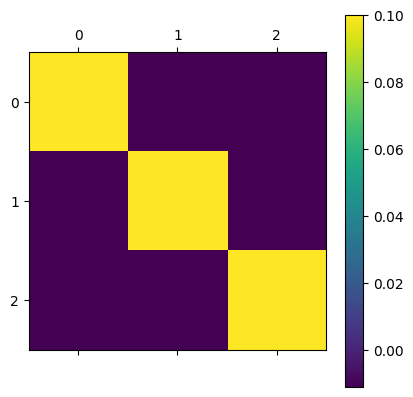

In [30]:
plt.matshow(np.cov(samplelow))
plt.colorbar()
plt.show()

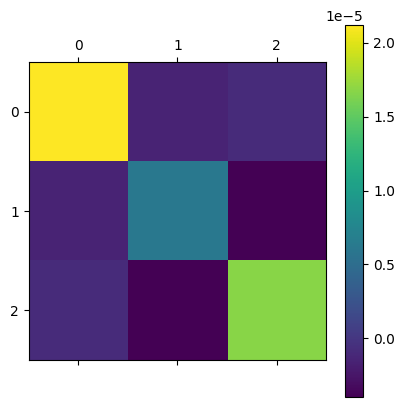

In [31]:
plt.matshow(np.cov(samplehi))
plt.colorbar()
plt.show()

# Spectrum of Dirichlet and Beta Covariance Matrices

Since we are analyzing the covariance matrix generated by the Dirichlet and beta random variables, the spectrum is easily available, as it can be diagonalized, so using blackbox eigensolvers from $\texttt{numpy}$ or $\texttt{scipy}$ such as ```eigh``` will suffice, since we know that the covariance matrix is symmetric and has real spectrum. Since we only have $T$ independent and random entries in our $T\times N$ matrix, there is no guarentee that self-averaging will occur and the eigenvalues will settle into a distribution. This motivates our first experiment, which is to construct a very large $T\times N$ matrix which has varying $q$ values down the column, and varying $\beta$ values across the columns. $N$ always equals 1500, so to change $q=N/T$, we change $T$ so that $q = \frac{5}{3},1.0,\frac{3}{5}$ for the first, second, and third row. The standard values of $\beta = 0.001,1.0,1000$ are the different columns. The results for both beta and Dirichlet random matrices are presented below.

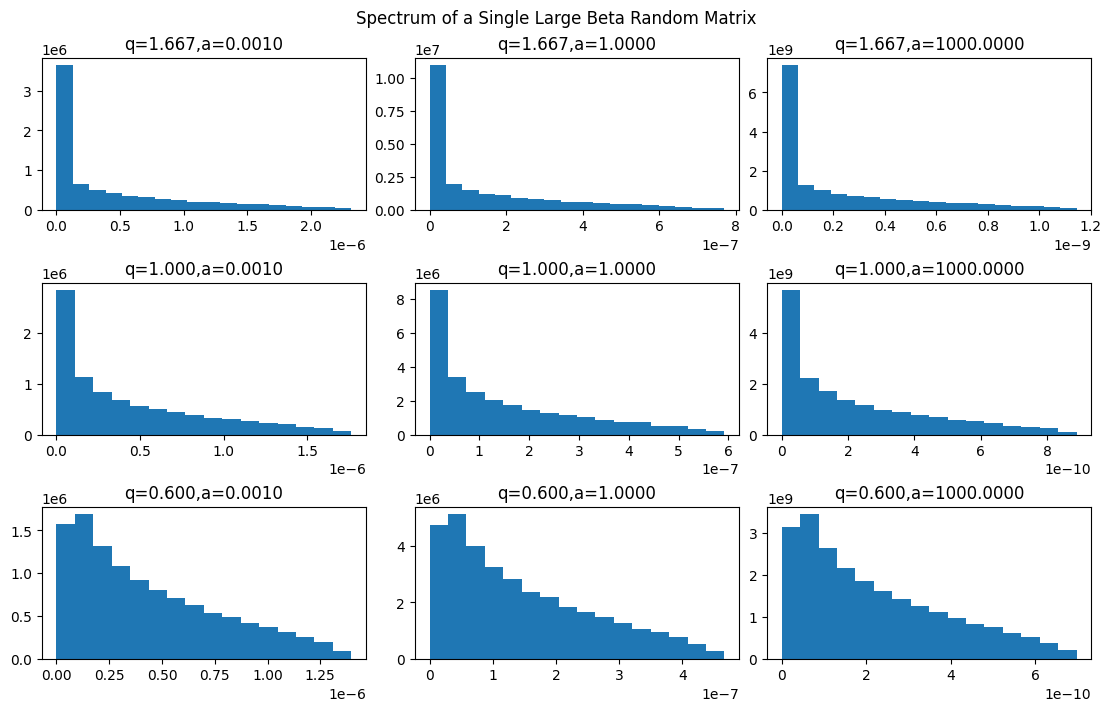

In [32]:
N = 1500
T = np.array([900,1500,2500])
a = np.array([0.001,1.,1000])
fig, axs = plt.subplots(ncols = 3, nrows = 3, figsize=(11, 7),
                        layout="constrained")
# add an artist, in this case a nice label in the middle...
for row in range(3):
    for col in range(3):
        A = betaRM(T[row],N,a[col],a[col])
        evals, evecs = LA.eigh(np.cov(A.T))
        axs[row,col].hist(evals.ravel(), bins = 'auto', density = True)
        axs[row,col].set_title('q=%5.3f,' %float(N/T[row]) + 'a=%5.4f' %a[col])

fig.suptitle('Spectrum of a Single Large Beta Random Matrix')
plt.show()

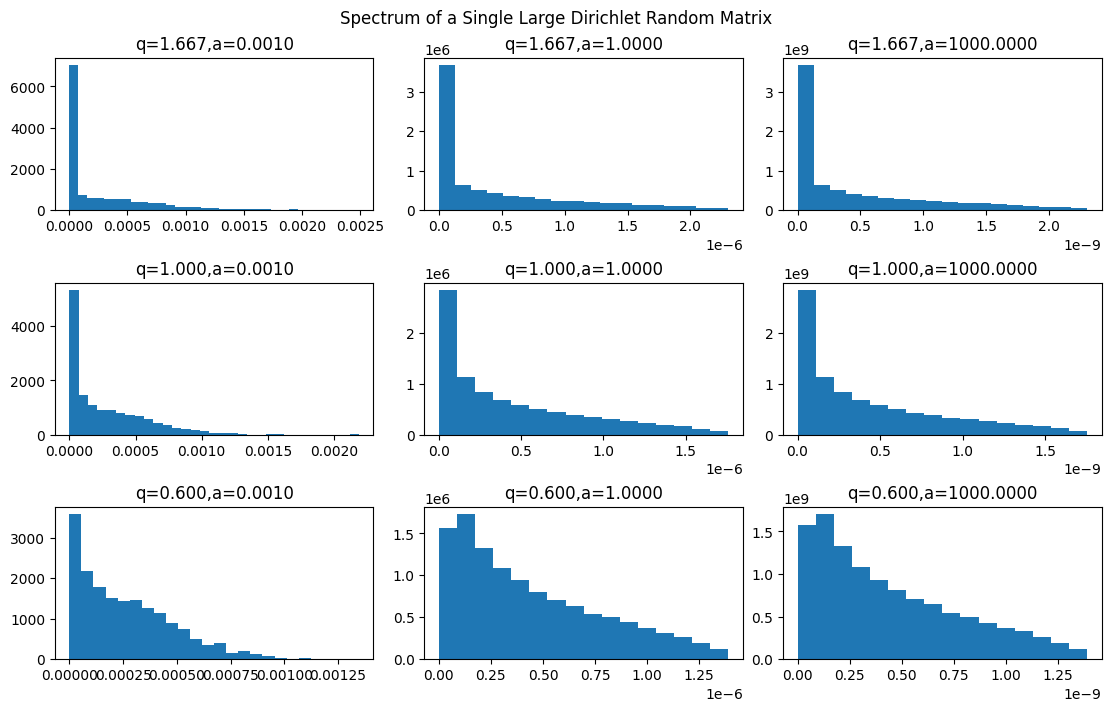

In [33]:
N = 1500
T = np.array([900,1500,2500])
a = np.array([0.001,1.,1000])
fig, axs = plt.subplots(ncols = 3, nrows = 3, figsize=(11, 7),
                        layout="constrained")
# add an artist, in this case a nice label in the middle...
for row in range(3):
    for col in range(3):
        A = dirRM(T[row],a[col]*np.ones(N))
        evals, evecs = LA.eigh(np.cov(A.T))
        axs[row,col].hist(evals.ravel(), bins = 'auto', density = True)
        axs[row,col].set_title('q=%5.3f,' %float(N/T[row]) + 'a=%5.4f' %a[col])

fig.suptitle('Spectrum of a Single Large Dirichlet Random Matrix')
plt.show()

Based on the above results, we see interesting properties for the spectrum of a large beta and Dirichlet matrices. The biggest observation is the prevalence of trivial eigenvalues when $q>1$. This is due to $N>T$ and the $\text{rank}(\mathbf{A}) \leq \min(N,T) = T$, so there are $N-T$ zero eigenvalues. Additionally, when $\beta\ll 1$, we see the sparcity condition also makes 0 eigenvalues more prevalent. We see a slow decay of the quantity of eigenvalues as the magnitude increases. Lastly, while we see the same patterns in the beta and Dirichlet random matrices, we notice that the support of the Dirichlet case is much larger by an order of magnitude, which causes the amount of eigenvalues to be smaller by an order of magnitude. This dependence on $q$ is similar to the Marchenko - Pastur distribution visualized below for $q<1, q>1$.

In [26]:
# M-P computation
def marchpast(x, q, **kwargs):
    "Marchenko-Pastur distribution"
    def mplus(a):
        "Element wise maximum of (a,0)"
        return np.maximum(a, np.zeros_like(a))
    shift = kwargs.get('shift', 0)
    scale = kwargs.get('scale', 1)
    var = kwargs.get('var',1)
    qplus = var**2 *(1 + q ** 0.5) ** 2
    qminus = var**2 * (1 - q ** 0.5) ** 2
    
    return np.sqrt(  scale * mplus(qplus  - (x-shift)) *  mplus((x - shift) - qminus)) / ( 2*np.pi* var**2**q*(x - shift))




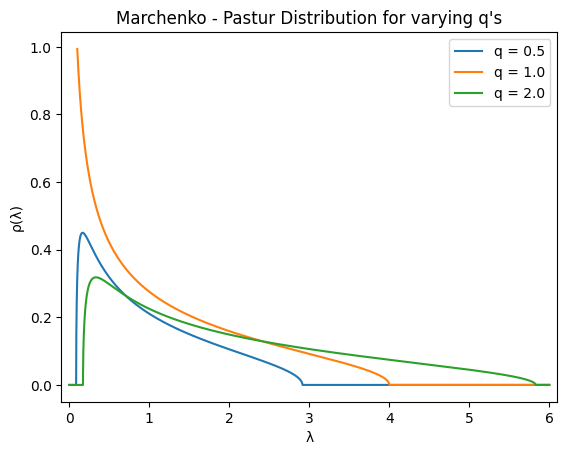

In [42]:
x1 = np.linspace(0.00001,6,10001)
x2 = np.linspace(0.1,6,10001)
x3 = np.linspace(0.00001,6,10001)
plt.plot(x1, marchpast(x1,0.5, shift = 0., scale = 1))
plt.plot(x2, marchpast(x2,1.0, shift = 0., scale = 1))
plt.plot(x3, marchpast(x3,2.0, shift = 0., scale = 0.5),0.0,0.5)
plt.xlabel('λ')
plt.ylabel('ρ(λ)')
plt.title("Marchenko - Pastur Distribution for varying q's")
plt.xlim([-0.1,6.1])
plt.legend(['q = 0.5','q = 1.0', 'q = 2.0'])
plt.show()

Using the Marchenko - Pastur code we attempt to fit the Marchenko - Pastur distribution to the spectrum of a large beta and Dirichlet random matrix, but we see there is not a good fit for these eigenvalues. While the Marchenko - Pastur distribution looks relatively well for the beta case, one should notice that we have scaled the distribution up, which means it is no longer a probability distribution.

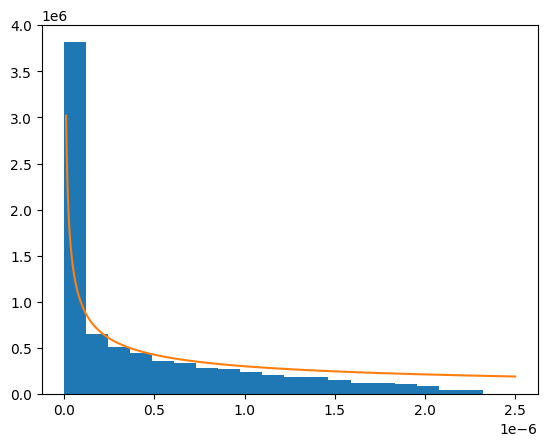

In [36]:
myMat = betaRM(900,1500,0.000001,0.000001)
evals, evecs = LA.eigh(np.cov(myMat.T))
nn, bb, patches = plt.hist(evals.ravel(), bins = 'auto', density = True)
x = np.linspace(0.00000001,2.5e-6,1001)
plt.plot(x, marchpast(x,0.999999999999, shift = 0., scale = 900000))
plt.show()

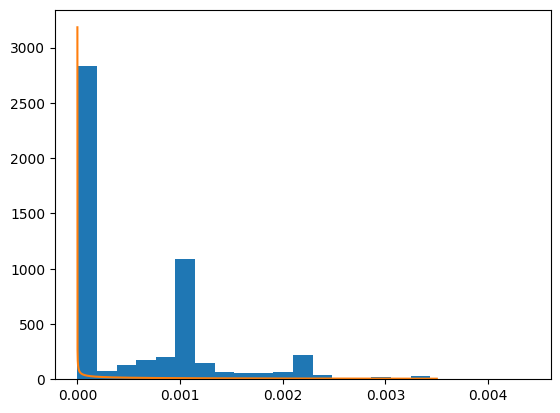

In [37]:
myMat = dirRM(900,0.0001* np.ones(1500))
evals, evecs = LA.eigh(np.cov(myMat.T))
nn, bb, patches = plt.hist(evals.ravel(), bins = 'auto', density = True)
x = np.linspace(0.00000001,0.0035,10001)
plt.plot(x, marchpast(x,0.999999999, shift = 0., scale = 1))
plt.show()

# Convergence of Dirichlet Random Matrices's Spectrum to a distribution.
## Convergence of the Distribution
Thus far, we have constructed Dirichlet and beta random matrices, and observed the spectrum of one very large $N \times N$ covariance matrix. There are $T$ independent rows of the matrix as opposed to the $NT$ independent entries for a standard GOE $T\times N$ matrix. This next section is dedicated to answering the following question: even without the independence in the rows of a Dirichlet or beta random matrix, does the spectrum of the $N\times N$ covariance matrix converge to a distribution? 

In an attempt to answer this question, we have devised the following numerical experiment. For a small random matrix, we numerically bin the entire spectrum of the covariance matrix, and we repeat this processes a few times. As we have more and more trials -- i.e. more random matrices that are constructed anew each trial, numerically diagonalized, and spectrum binned -- we should expect the spectrum to settle into a distribution. However, if adding more trials obfuscates or changes the shape of the distribution in an unpredictable manner, then the lack of independence and lack of self-averaging are most likely to blame.

More technically, we try this experiment on 5,10,100,1000, and 5000 trials for both the Dirichlet and beta distributed random matrices with $\beta$ values of $0.001, 1.0,1000$ in three different figures respectively.

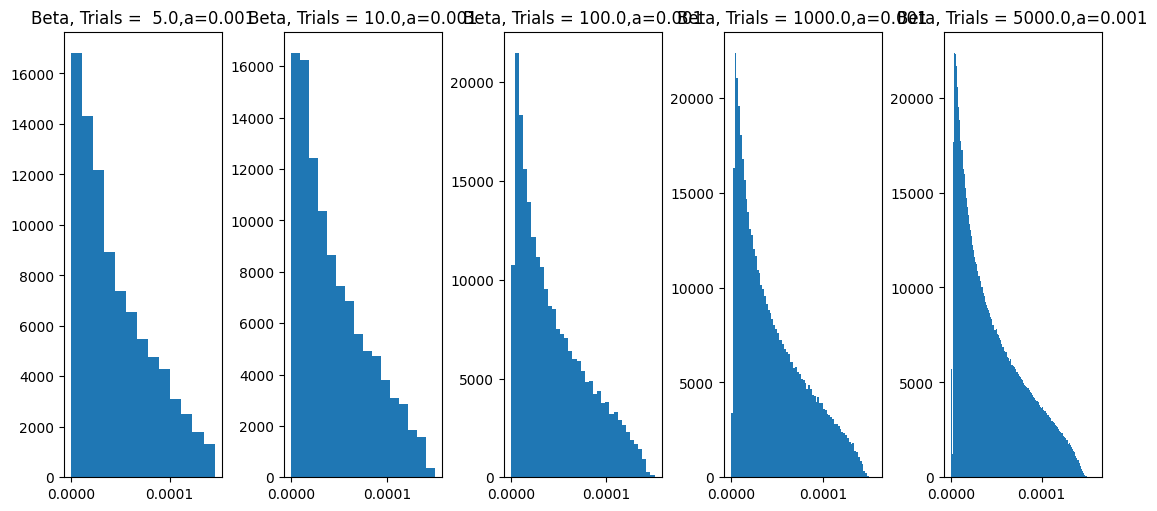

In [38]:
trials = np.array([5,10,100,1000,5000])
N = 150
T = 250
evals1 = np.array([])
evals2 = np.array([])
x = np.linspace(0,5e-5,1001)
fig, axs = plt.subplots(ncols = 5, nrows = 1, figsize=(11, 5), layout = 'constrained')
# add an artist, in this case a nice label in the middle...
for col in range(5):
    evals1 = np.array([])
    evals2 = np.array([])
    for i in range(trials[col]):
        A = betaRM(T,N,0.001,0.001)
        newevals1, evecs1 = LA.eigh(np.cov(A.T))
        evals1 = np.append(evals1, newevals1)
        #A = dirRM(T,0.001*np.ones(N))
        #newevals2, evecs2 = LA.eigh(np.cov(A.T))
        #evals2 = np.append(evals2, newevals2)
    axs[col].hist(evals1.ravel(), bins = 'auto', density = True)
    #axs[col].hist(evals2.ravel(), bins = 'auto', density = True)
    #axs[col].plot(x, marchpast(x,6e-10, shift = -0.99998999, scale = 1))
    #axs[col].set_xlim(0.0, 0.15)
    #axs[col].set_ylim(0.0, 7000)
    axs[col].set_title('Beta, Trials = %4.1f,' %trials[col] + 'a=0.001')

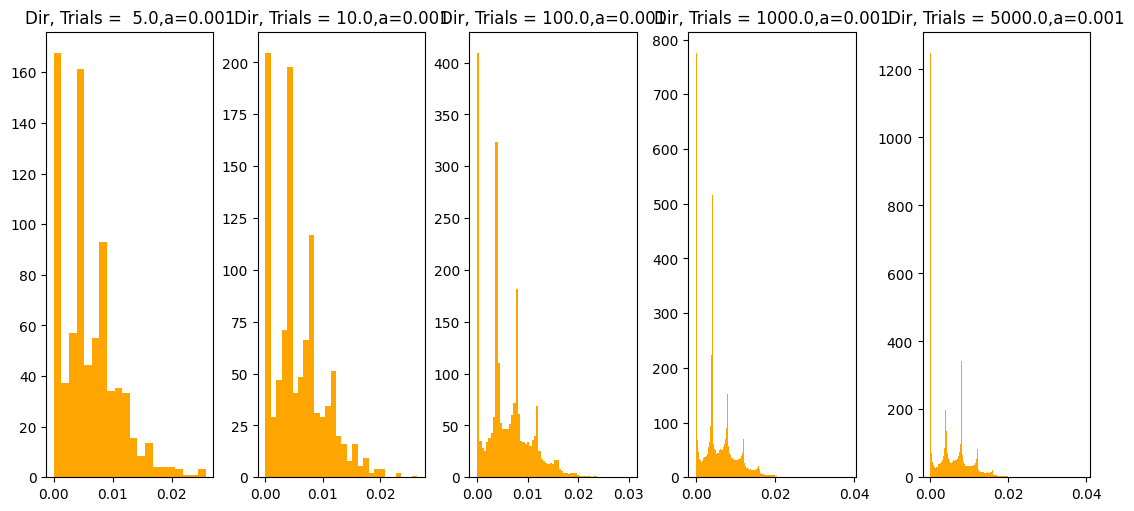

In [39]:
trials = np.array([5,10,100,1000,5000])
N = 150
T = 250
evals1 = np.array([])
#evals2 = np.array([])
x = np.linspace(0,5e-5,1001)
fig, axs = plt.subplots(ncols = 5, nrows = 1, figsize=(11, 5), layout = 'constrained')
# add an artist, in this case a nice label in the middle...
for col in range(5):
    evals1 = np.array([])
    #evals2 = np.array([])
    for i in range(trials[col]):
        #A = betaRM(T,N,0.001,0.001)
        #newevals1, evecs1 = LA.eigh(np.cov(A.T))
        #evals1 = np.append(evals1, newevals1)
        A = dirRM(T,0.001*np.ones(N))
        newevals1, evecs1 = LA.eigh(np.cov(A.T))
        evals1 = np.append(evals1, newevals1)
    axs[col].hist(evals1.ravel(), color = 'orange', bins = 'auto', density = True)
    #axs[col].hist(evals2.ravel(), bins = 'auto', density = True)
    #axs[col].plot(x, marchpast(x,6e-10, shift = -0.99998999, scale = 1))
    #axs[col].set_xlim(0.0, 0.15)
    #axs[col].set_ylim(0.0, 7000)
    axs[col].set_title('Dir, Trials = %4.1f,' %trials[col] + 'a=0.001')

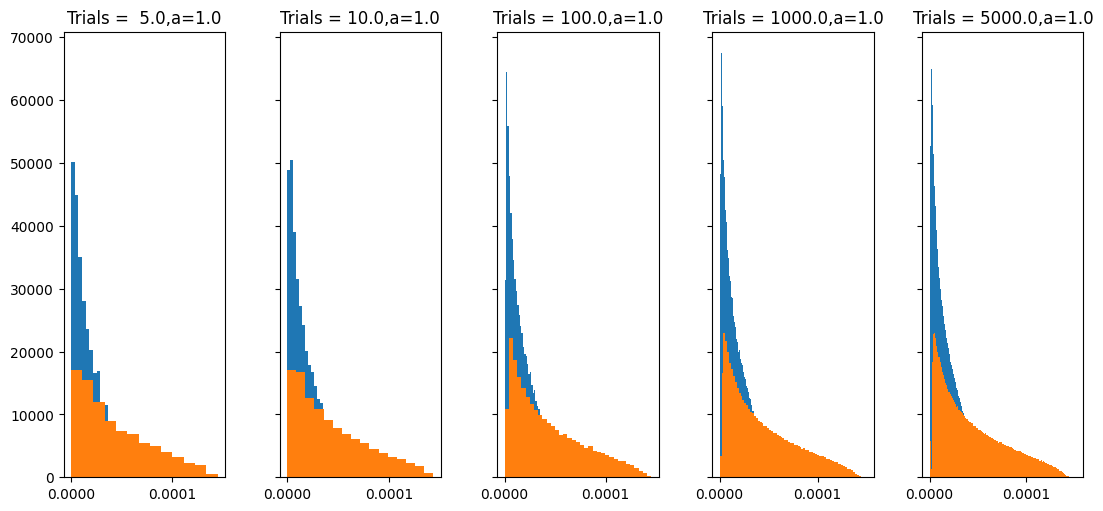

In [40]:
trials = np.array([5,10,100,1000,5000])
N = 150
T = 250
evals1 = np.array([])
evals2 = np.array([])
x = np.linspace(0,5e-5,1001)
fig, axs = plt.subplots(ncols = 5, nrows = 1, figsize=(11, 5),
                          sharex='col', sharey='row',layout="constrained")
# add an artist, in this case a nice label in the middle...
for col in range(5):
    evals1 = np.array([])
    evals2 = np.array([])
    for i in range(trials[col]):
        A = betaRM(T,N,1,1)
        newevals1, evecs1 = LA.eigh(np.cov(A.T))
        evals1 = np.append(evals1, newevals1)
        A = dirRM(T,np.ones(N))
        newevals2, evecs2 = LA.eigh(np.cov(A.T))
        evals2 = np.append(evals2, newevals2)
    axs[col].hist(evals1.ravel(), bins = 'auto', density = True)
    axs[col].hist(evals2.ravel(), bins = 'auto', density = True)
    #axs[col].plot(x, marchpast(x,6e-10, shift = -0.99998999, scale = 1))
    axs[col].set_title('Trials = %4.1f,' %trials[col] + 'a=1.0')

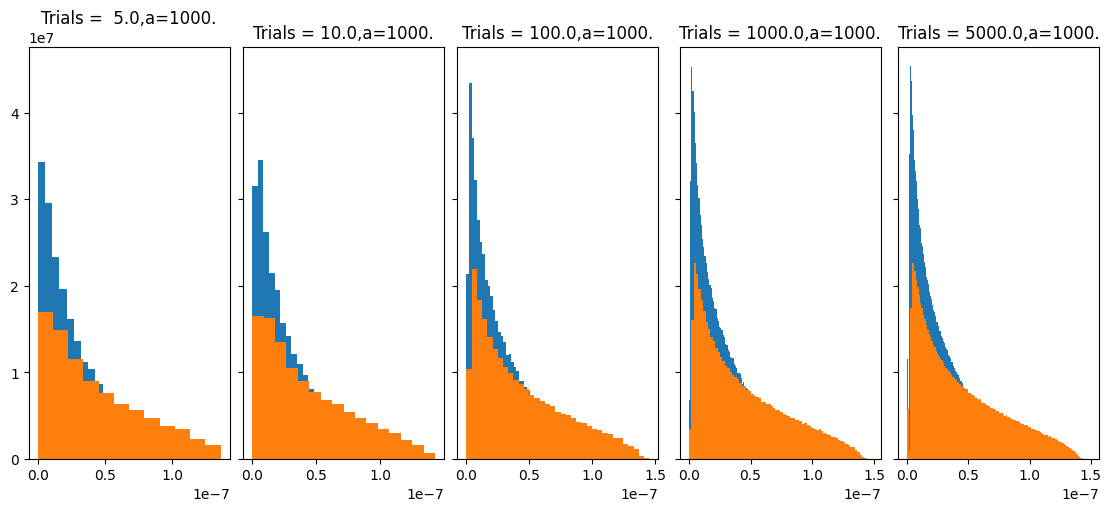

In [41]:
trials = np.array([5,10,100,1000,5000])
N = 150
T = 250
evals1 = np.array([])
evals2 = np.array([])
x = np.linspace(0,5e-5,1001)
fig, axs = plt.subplots(ncols = 5, nrows = 1, figsize=(11, 5),
                          sharex='col', sharey='row',layout="constrained")
# add an artist, in this case a nice label in the middle...
for col in range(5):
    evals1 = np.array([])
    evals2 = np.array([])
    for i in range(trials[col]):
        A = betaRM(T,N,1000,1000)
        newevals1, evecs1 = LA.eigh(np.cov(A.T))
        evals1 = np.append(evals1, newevals1)
        A = dirRM(T,1000*np.ones(N))
        newevals2, evecs2 = LA.eigh(np.cov(A.T))
        evals2 = np.append(evals2, newevals2)
    axs[col].hist(evals1.ravel(), bins = 'auto', density = True)
    axs[col].hist(evals2.ravel(), bins = 'auto', density = True)
    #axs[col].plot(x, marchpast(x,6e-10, shift = -0.99998999, scale = 1))
    axs[col].set_title('Trials = %4.1f,' %trials[col] + 'a=1000.')

From the three code blocks and figures above, we see that all three cases $\beta = 0.001, 1.0$, and $1000.$ do seem to converge to a distribution. For the $\beta = 0.001$ case, we see two different phenomena for the beta and Dirichlet cases, where we see a drastically different distribution from the other cases. First, recall that when $\beta\ll 1$, we get a very sparse matrix with only a few nonzero per row of magnitude $\mathcal{O}(1)$. This sparsity explains the peaks of the distribution. Since we have mostly sparce matrices, the probability of two nonzero entries hitting (when constructing the covariance matrix) is quite low, which explains the peak at 0, the trivial eigenvalues. However, even within the sparse setting, it is possible to have a few nonzeros in a row, which have to add up to 1. If each nonzero value was equal, we would have only the sharp uniformly spaced peaks ($\sim$ 0.005 distance between them). While we do see these sharp peaks, we also see a smoothing between these peaks as well, which is from the fact that if we have a few nonzero entries per row, they only have to add up to 1, they don't need to all be equal. This smears the nice peaks into the distribution we see above. Lastly, we don't see great agreement between the beta and Dirichlet spectrum. In fact for $\beta = 0.001$ in the beta distribution case, it is much more similar to the other values of $\beta$.

The last two cases -- when $\beta = 1, 1000$, respectively, can be described together. Both display a large peak close to (but not exactly at) 0. Then as the magnitude increases, the amount of eigenvalues with that magnitude decreases. For $\beta = 1$, we see that the support of the distribution is 0 to 5e-5 and 1e-4 for the beta and Dirichlet distribution, respectively, but as $\beta$ increases to $\beta = 1000$, we see the support shrinks to 0 to 7.5e-8 and 1.5e-7. The distribution between the beta and Dirichlet case appear to be the same, but the larger support for the Dirichlet spectrum reduces the number of eigenvalues at that magnitude.  While these two cases settle into a distribution, we next explore if this is the Marchenko - Pastur distribution, a variant of it, or another distribution altogether. 

## Qualities of the Distribution of Dirichlet Random Matrices' Spectrum
As we showed above, as we increase the number of trials of small beta or Dirichlet random matrices, for any $\beta$ parameter, the histograms of the eigenvalues settle into a distribution, but the question remains, what is the distribution? A potential candidate would be the Marchenko - Pastur distribution as this is what arises in a covariance matrix constructed using the GOE and has the built in $q = \frac{N}{T}$ parameter. 

All the cases above were run using $N=150, T=250 \implies q = 0.6<1$. This means we have an overdetermined system for the $T\times N$ matrix. We should not expect undue zero eigenvalues in this case, just like with the Marchenko - Pastur distribution for a GOE matrix when $q<1$. The next set of experiments aim to explore the dependence of the $q$ parameter on this distribution to compare it to the Marchenko - Pastur distribution. Since running many small experiments settle into a distribution, we run 1000 trials for three different $q$ ratios - $\frac{3}{5}, 1.0, \frac{5}{3}$. These values were chosen as they are the three categories of less than, equal to, and greater than 1, so we can explore these different behaviors. This experiment is then repeated for 3 different $\beta$ values, $\beta = 0.001,1., 1000$.

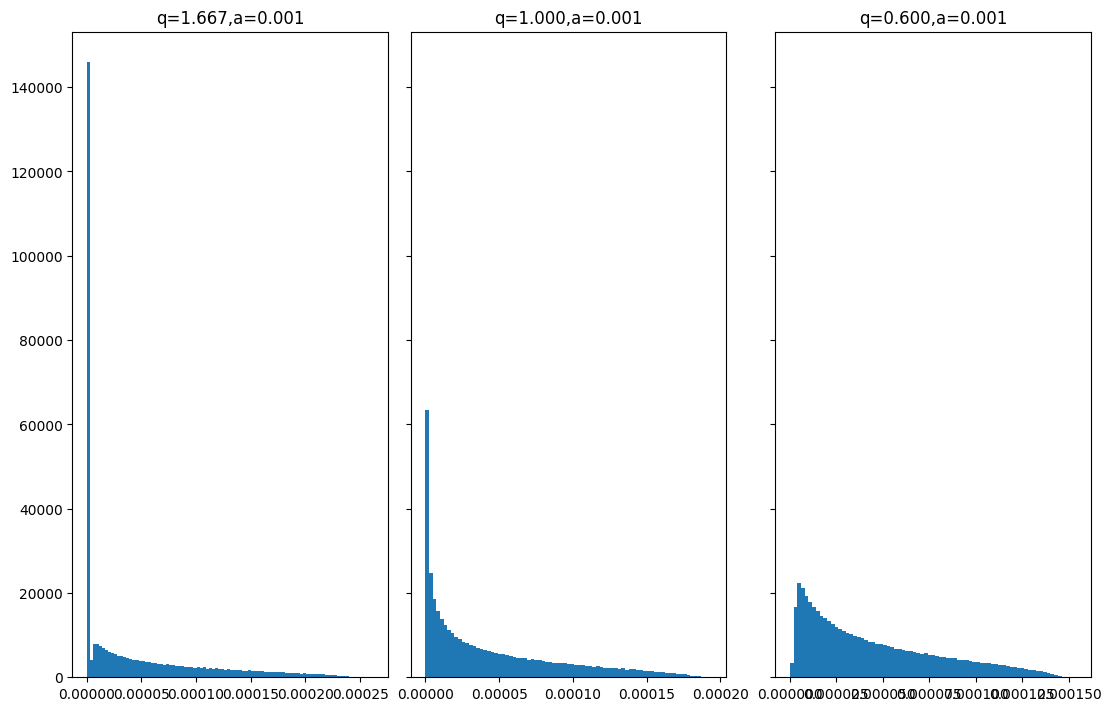

In [42]:
trials = 1000
N = 150
T = np.array([90,150,250])
evals = np.array([])
x = np.linspace(0,5e-5,1001)
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize=(11, 7),
                        sharex='col', sharey='row',layout="constrained")
# add an artist, in this case a nice label in the middle...
for col in range(3):
    evals = np.array([])
    for i in range(trials):
        A = betaRM(T[col],N,0.001,0.001)
        newevals, evecs = LA.eigh(np.cov(A.T))
        evals = np.append(evals, newevals)
    axs[col].hist(evals.ravel(), bins = 'auto', density = True)
    #axs[col].plot(x, marchpast(x,6e-10, shift = -0.99998999, scale = 1))
    axs[col].set_title('q=%5.3f,' %float(N/T[col]) + 'a=0.001')

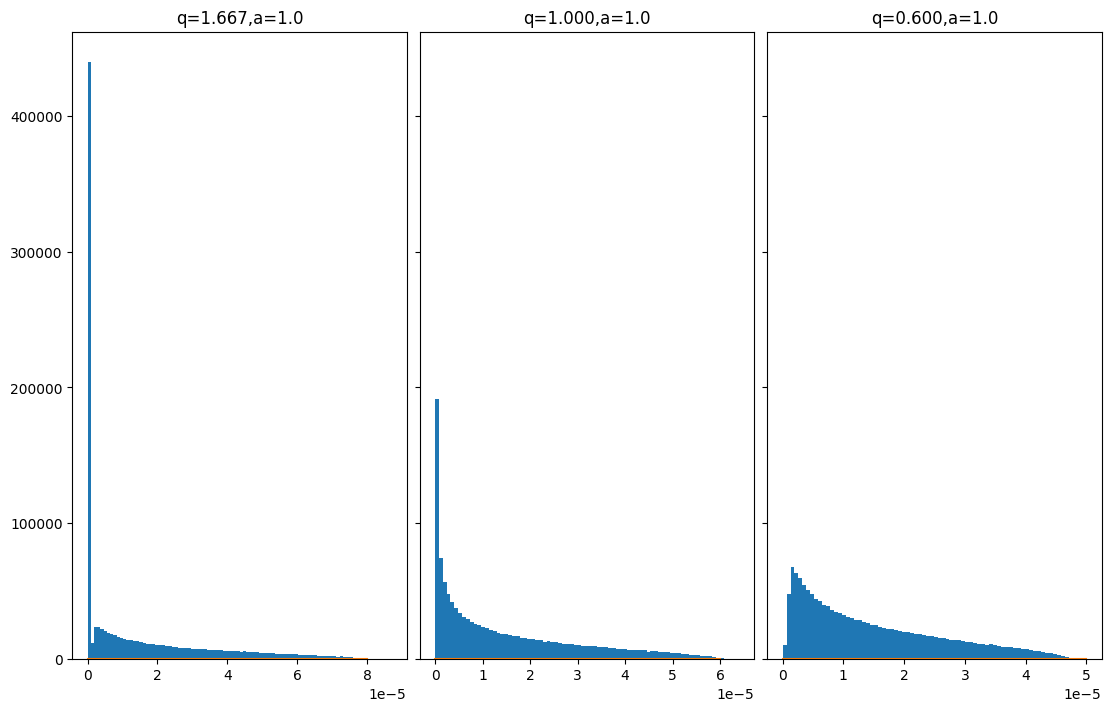

In [43]:
trials = 1000
N = 150
T = np.array([90,150,250])
evals = np.array([])
x1 = np.linspace(0.00000001,8e-5,1001)
x2 = np.linspace(0.00000001,6e-5,1001)
x3 = np.linspace(0.00000001,5e-5,1001)
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize=(11, 7),
                        sharex='col', sharey='row',layout="constrained")
# add an artist, in this case a nice label in the middle...
for col in range(3):
    evals = np.array([])
    for i in range(trials):
        A = betaRM(T[col],N,1,1)
        newevals, evecs = LA.eigh(np.cov(A.T))
        evals = np.append(evals, newevals)
    axs[col].hist(evals.ravel(), bins = 'auto', density = True)
    if col == 0:
        axs[col].plot(x1, marchpast(x1,1-0.9989346951545867,shift = 0,scale = 1))
    elif col == 1:
        axs[col].plot(x2, marchpast(x2,1-0.99979951545867,shift = 0,scale = 1))
    else:
        axs[col].plot(x3, marchpast(x3,1-0.9983346951545867,shift = 0,scale = 1))
    axs[col].set_title('q=%5.3f,' %float(N/T[col]) + 'a=1.0')

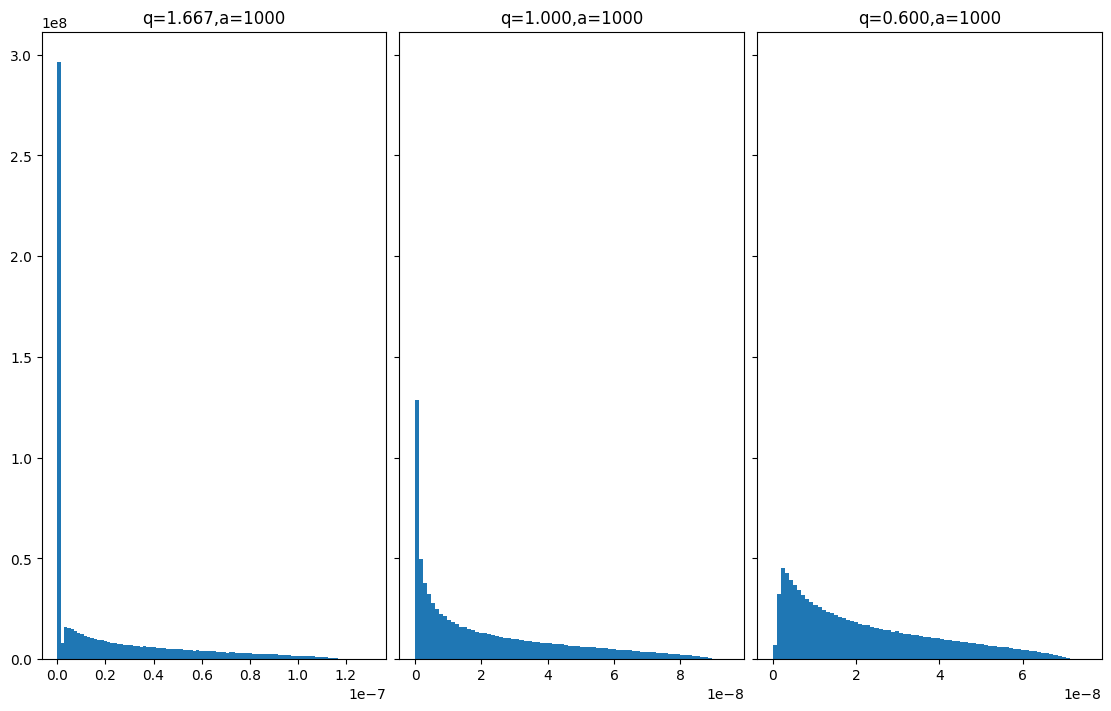

In [44]:
trials = 1000
N = 150
T = np.array([90,150,250])
evals = np.array([])
x = np.linspace(0,5e-5,1001)
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize=(11, 7),
                        sharex='col', sharey='row',layout="constrained")
# add an artist, in this case a nice label in the middle...
for col in range(3):
    evals = np.array([])
    for i in range(trials):
        A = betaRM(T[col],N,1000,1000)
        newevals, evecs = LA.eigh(np.cov(A.T))
        evals = np.append(evals, newevals)
    axs[col].hist(evals.ravel(), bins = 'auto', density = True)
    #axs[col].plot(x, marchpast(x,6e-10, shift = -0.99998999, scale = 1))
    axs[col].set_title('q=%5.3f,' %float(N/T[col]) + 'a=1000')

Again, we observe for $\beta = 0.001\ll 1$, we observe an expected tall peak around zero, which corresponds to the trivial eigenvalues. Since $N>T$, $\text{rank}(A) \leq \min(N,T) = T$, but $\mathbf{A}^\top\mathbf{A} \in\mathbb{R}^{N\times N}$, leading to about $N-T$ trivial eigenvalues. As we lower $q$ to 1 or $\frac{3}{5}$, we again observe a peak around 0, which differs from the Marchenko - Pastur distribution as when $q<1$, the smallest eigenvalues are bounded away from zero, and when $q=0$ there is a small chance of having a zero eigenvalue. This difference between our model and Marchenko - Pastur is due to the small $\beta$ parameter which means there are a large amount of zeros so trivial eigenvalues are to be expected. We also see more smearing in these cases as now there are $\mathcal{O}(N)$ nonzeros in the matrix itself.

Turning our attention to the other plots $\beta = 1, 100$ we observe the same behavior -- a tall peak around zero then a small separation from the rest of the distribution when $q=1.\bar{6}$, and other properties that are reminiscent of Marchenko - Pastur. This is why in the $\beta = 1$ case, we try to plot the Marchenko - Pastur distribution on top of the eigenvalue distributions. However, there are two important take aways. The first being that when I plot the Marchenko - Pastur distribution on top of the eigenvalues, I am using a modified one where there is now a shift and scale parameter. This is to get a better fit. Using the naive Marchenko - Pastur distribution, we know that $\lambda_\pm = (1\pm\sqrt{q})^2$. We use this formula below to try to figure out the $q$ value. When we solve for $q$, using that $\lambda_- = 0, \lambda_+ = 6.0e-5$, the naive Marchenko - Pastur distribution doesn't match the data at all. Even with the variant of Marchenko - Pastur where it can be scaled, (what is plotted against the eigenvalue histogram above), a good agreement isn't observed. If the peak is matched, the tail decays too slow compared to the experimental results. If the tail decay is matched, the peak is way overestimated. This leads to the conclusion that while there are properties that are reminiscent of Marchenko - Pastur in the beta and Dirichlet random matrix case, the true distribution is at best a variant of Marchenko - Pastur, and at worst, another distribution entirely.

In [45]:
q = (np.sqrt(6e-5) - 1) **2
print(q)

0.9845680666151704


In [46]:
qm = (1-np.sqrt(q)) **2
print (qm)

5.999999999999925e-05


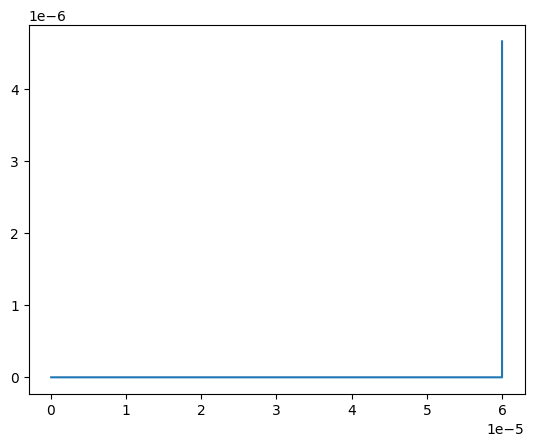

In [47]:
x = np.linspace(0.00000004,0.00006,100001)
plt.plot(x, marchpast(x,q,shift = 0,scale = 1))
plt.show()

# Conclusions and Future Directions
## Conclusions
In this project, we have constructed a way of sampling vectors from the beta and Dirichlet distirbution and then concatenated these vectors to construct random matrices. A brief analysis of the two extreme cases for $\beta$ and its effect on the structure of the covariance matrix is performed and numerically verified. We investigate how $q$ and $\beta$ interact and affects the spectrum of a very large beta and Dirichlet random matrix, which was found not to have a Marchenko - Pastur distribution. We then numerically showed that both beta and Dirichlet random matrices settle into a distribution and how $q$ and $\beta$ shape this distribution. While that is interesting, we notice the first divergence in results between beta and Dirichlet random matrices when $\beta = 0.001$. Lastly, we try to fit both the naive and modified Marchenko - Pastur distribution to these eigenvalue histograms to no avail, leading to the conclusion that this distribution is not the same as the Marchenko - Pastur distribution for Wishart random matrices.

## Future Directions
While we have explored the Dirichlet Random Matrix problem in terms of eigenvalues and their probability density, almost all of the results were numerical in flavor. This was due to the assumption that each entry is no longer independent, as it will affect the values of every other entry in its row. However, this system is far from deterministic as each row is an independent sampling from the Dirichlet distribution. This might be the perfect setting to apply similar methodologies as [Bryson, Vershynin, Zhao '19](https://arxiv.org/pdf/1912.12724), where the authors consider a $p\times p$ covariance matrix under a block-indenpendent model and a random tensor model. The paper also includes a vast literature review which talks about the other types of random matrices that have already been solved such as spherically symmetric distribution sampled matrices, Orthogonally invariant matrices, Toeplitz, and Markov matrices to name a few. Using the results and same ideas as these paper, the goal would be to prove that the spectrum of the $p\times p$ covariance matrix generated from the Dirchlet or Beta distribution converge weakly or in distribution to a variant of the Marchenko-Pastur distribution, or another distibution altogether. This law would have to take into account $N, T, q:= N/T, \beta, \texttt{len}(\beta)$, or how many parameters the system is modeling.

Numerically, there are still questions to be answered. In terms of numerically finding the distribution PDF, an interesting experiment not performed above would be how does the distribution depend on the number or variables we are considering. For example, the Dirichlet distibution takes in $N$ parameters to sample $N$ points from the distribution, but we see that the beta distribution (which has two parameters) has less variance in the support of the distribution compared to the Dirichlet distribution which has 150 parameters. Does the number of variables/parameters change the spectral density continuously, and what is the overall effect on the number of parameters? Related to this, but more pressing, what is causing the smoothness in the beta spectrum when $\beta = 0.001$ for all $q=\frac{3}{5},1.0,\frac{5}{3}$ and why the Dirichlet distribution for these are reminiscent of smeared peaks. Lastly, we note that we have set every (hyper)parameter in $\beta$ to the same value, but it would be interesting to see how altering these values can impact the spectrum of the random covariance matrix.

# TEST TEST TEST

In [48]:
from scipy.stats import johnsonsb
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from matplotlib.widgets import Button, Slider

In [49]:
trials = np.array([10000])
a = 1
N = 150
T = 160
ratio = N/T
evals1 = np.array([])
evals2 = np.array([])
evals3 = np.array([])
evals4 = np.array([])
# add an artist, in this case a nice label in the middle...
evals1 = np.array([])
#evals2 = np.array([])
for i in range(trials[0]):
    A = betaRM(T,N,a,a)
    AtA = np.cov(A.T)
    newevals1 = LA.eigvalsh(AtA)
    #newevals2 = LA.eigvals(AtA)
    #newevals3 = sp.linalg.eigvalsh(AtA)
    #newevals4 = sp.linalg.eigvals(AtA)
    evals1 = np.append(evals1, newevals1)
    #evals2 = np.append(evals2, np.real(newevals2))
    #evals3 = np.append(evals3, newevals3)
    #evals4 = np.append(evals4, np.real(newevals4))

In [50]:
# evalstrunk1 = np.sort(evals1)[:999]
# evalstrunk2 = np.sort(evals2)[:999]
# evalstrunk3 = np.sort(evals3)[:999]
# evalstrunk4 = np.sort(evals4)[:999]
evalstrunk1 = np.sort(evals1)[10000:]
# evalstrunk2 = np.sort(evals2)[10000:]
# evalstrunk3 = np.sort(evals3)[10000:]
# evalstrunk4 = np.sort(evals4)[10000:]

evalstrunk1


array([2.11054253e-09, 3.28842782e-09, 3.54441347e-09, ...,
       6.20677952e-05, 6.22289785e-05, 6.24181513e-05])

In [3]:
from skrmt.ensemble.spectral_law import MarchenkoPasturDistribution


beta = 1
sigma = 0.00384


# beta = 2
# sigma = 0.00272


# beta = 4
# sigma = 0.00193

x1 = np.linspace(0, 0.000061, 10001)
mpl = MarchenkoPasturDistribution(beta=beta, ratio=ratio, sigma=sigma)
y1 = mpl.pdf(x1)

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=(11, 5), layout = 'constrained')
axs.hist(evalstrunk1.ravel(), bins = 'auto', density=True, label='eigenvalues')
axs.plot(x1, y1, label=f"MP $q$ = {ratio}, $\\beta$ = {beta} ", lw = 2)
axs.legend()
axs.set_xlabel('$\\lambda$')
axs.set_ylabel('$\\rho(\\lambda)$')
axs.set_title(f"N = {trials[0]}, q = {N/T}, $\\alpha$ = {a} ")
plt.show()



ModuleNotFoundError: No module named 'skrmt'

Max1 = 0.0001062933422291
Min1 = 0.0000909307528580


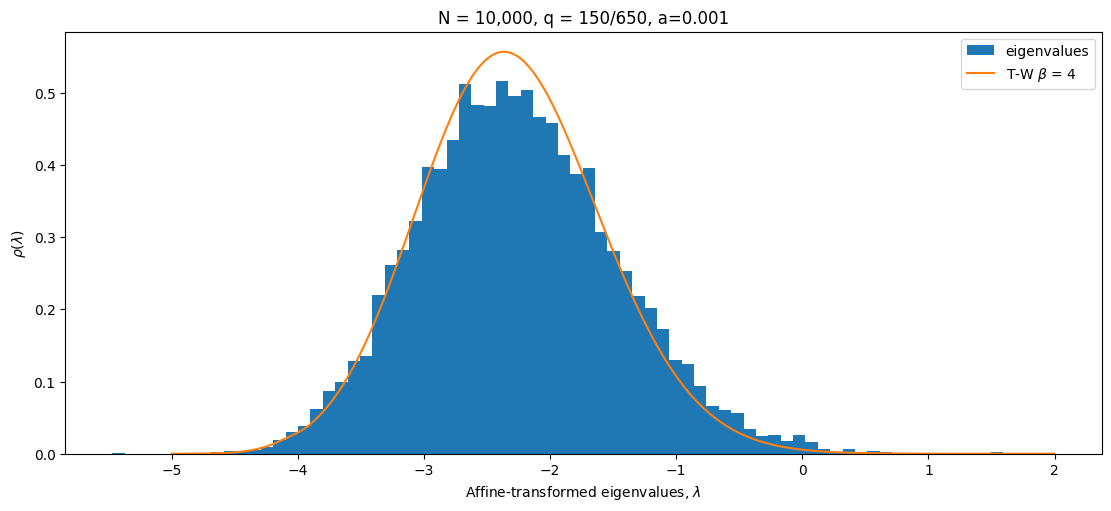

In [244]:
from skrmt.ensemble.spectral_law import TracyWidomDistribution

#evalsaffine = 490000* evalstrunk1 - 49.75 ## beta = 2
evalsaffine = 460000* evalstrunk1 - 47.3 ## beta = 4

maxeval1 = np.max(evalstrunk1)
print("Max1 = %4.16f"%maxeval1)
# maxeval2 = np.max(evalstrunk2)
# print("Max2 = %4.16f"%maxeval2)
# maxeval3 = np.max(evalstrunk3)
# print("Max3 = %4.16f"%maxeval3)
# maxeval4 = np.max(evalstrunk4)
# print("Max1 = %4.16f"%maxeval4)

mineval1 = np.min(evalstrunk1)
print("Min1 = %4.16f"%mineval1)
# mineval2 = np.min(evalstrunk2)
# print("Min2 = %4.16f"%mineval2)
# mineval3 = np.min(evalstrunk3)
# print("Min3 = %4.16f"%mineval3)
# mineval4 = np.min(evalstrunk4)
# print("Min4 = %4.16f"%mineval4)

beta = 4

x = np.linspace(-5, 2, 10001)
twd = TracyWidomDistribution(beta=beta)
y_pdf = twd.pdf(x)

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=(11, 5), layout = 'constrained')
axs.hist(evalsaffine.ravel(), bins = 'auto', density=True, label='eigenvalues')
#axs.hist(evalstrunk2.ravel(), bins = 'auto', label='np')
#axs.hist(evalstrunk3.ravel(), bins = 'auto', label='sp H')
#axs.hist(evalstrunk4.ravel(), bins = 'auto', label='sp' )
#axs[col].hist(evals2.ravel(), bins = 'auto', density = True)
#axs[col].plot(x, marchpast(x,6e-10, shift = -0.99998999, scale = 1))
#axs[col].set_xlim(0.0, 0.15)
#axs[col].set_ylim(0.0, 7000)
axs.plot(x, y_pdf, label=f"T-W $\\beta$ = {beta}")
axs.legend()
axs.set_xlabel('Affine-transformed eigenvalues, $\\lambda$')
axs.set_ylabel('$\\rho(\\lambda)$')
axs.set_title('N = 10,000, q = 150/650, a=0.001')
plt.show()



In [1]:
from TracyWidom import TracyWidom

x = np.linspace(0, 10, 101)
tw1 = TracyWidom(beta=1)  # allowed beta values are 1, 2, and 4
pdf = tw1.pdf(x)
cdf = tw1.cdf(x)


plt.plot(x,pdf)

ModuleNotFoundError: No module named 'TracyWidom'

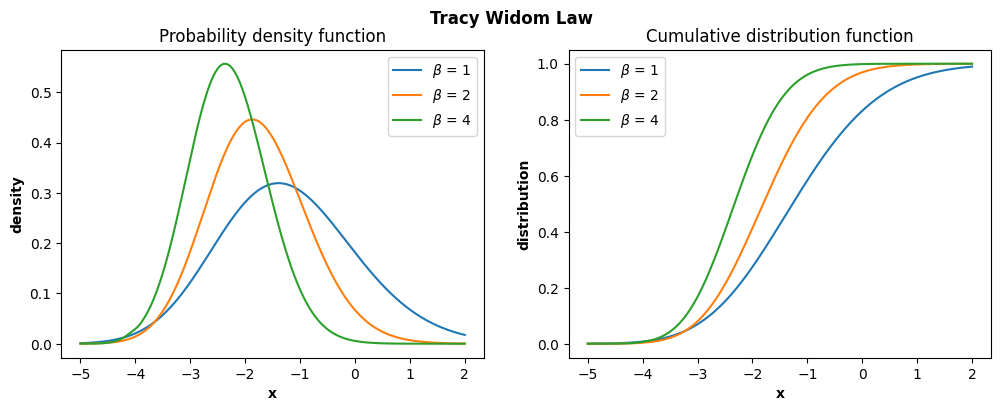

In [142]:
x = np.linspace(-5, 2, num=1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

for beta in [1,2,4]:
    twd = TracyWidomDistribution(beta=beta)

    y_pdf = twd.pdf(x)
    y_cdf = twd.cdf(x)

    ax1.plot(x, y_pdf, label=f"$\\beta$ = {beta}")
    ax2.plot(x, y_cdf, label=f"$\\beta$ = {beta}")

ax1.legend()
ax1.set_xlabel("x", fontweight="bold")
ax1.set_ylabel("density", fontweight="bold")
ax1.set_title("Probability density function")

ax2.legend()
ax2.set_xlabel("x", fontweight="bold")
ax2.set_ylabel("distribution", fontweight="bold")
ax2.set_title("Cumulative distribution function")

fig.suptitle("Tracy Widom Law", fontweight="bold")
plt.show()

In [135]:
mean = sp.stats.moment(evalstrunk1, 1, center = (maxeval1-mineval1)/2)
vari = sp.stats.moment(evalstrunk1, 2)
skew = sp.stats.moment(evalstrunk1, 3)
kurt = sp.stats.moment(evalstrunk1, 4)

print('mean | variance | skewness | kurtosis')
print('%4.24f | %4.16f | %4.16f | %4.16f' % (mean, vari, skew, kurt))

mean | variance | skewness | kurtosis
0.000090230831528118884619 | 0.0000000000029657 | 0.0000000000000000 | 0.0000000000000000


2024-08-07 12:45:05.748 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted johnsonsb distribution with error=34662721.558282)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
johnsonsb,3.466272e+07,-1768.400752,-1719.543605,0.006831,0.007403,2.393019e-71


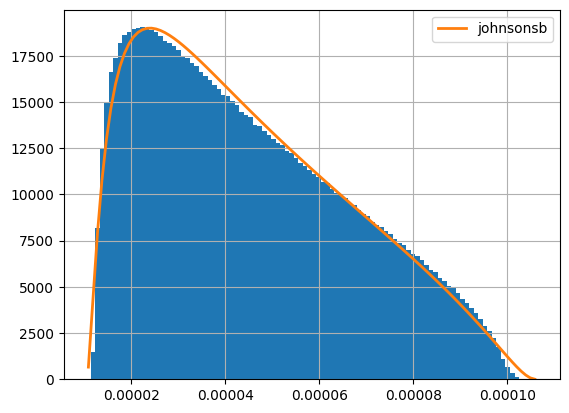

In [116]:
f = Fitter(evalstrunk1,
          distributions= ['johnsonsb'])
f.fit()
f.summary()

In [117]:
f.get_best(method = 'kl_div')

{'johnsonsb': {'a': np.float64(0.5939719193822709),
  'b': np.float64(0.8163865703513389),
  'loc': np.float64(1.0360400445386336e-05),
  'scale': np.float64(9.598454137808277e-05)}}

In [104]:
f.fitted_param["johnsonsb"]

(np.float64(0.632713417302895),
 np.float64(0.7656135339088856),
 np.float64(9.362973982409566e-06),
 np.float64(0.00010246407475943363))

In [124]:
mineval = np.min(evals1)

mineval

-8.951328180416688e-20

In [125]:
maxeval = np.max(evals1)

maxeval

0.00015669678666559126

In [118]:
a, b = 0.632713417302895, 0.7656135339088856

mean, var, skew, kurt = johnsonsb.stats(a, b, moments='mvsk')
print(mean, var, skew, kurt)


0.34888313864390075 0.05409385638032692 0.5825349197321236 -0.6162790672644429


In [74]:
a,b = johnsonsb.fit(evalstrunk1)

ValueError: too many values to unpack (expected 2)